# Import Necessary Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import math
import random
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from sklearn.linear_model import Perceptron
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import VotingClassifier

from imblearn.combine import SMOTEENN
from collections import Counter

from pyemd import emd_samples
from scipy.stats import ttest_ind

#### Disable runtime warnings

In [2]:
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

# Heartbeat Annotation

In [3]:
N = ['N', 'L', 'R', 'e', 'j']
SVEB = ['A', 'a', 'J', 'S']
VEB = ['V', 'E']
F = ['F']
Q = ['l', 'f', 'Q']
Non_beat_anns = ['[', ']', '!', 'x', '(', ')', 'p', 't', 'u', '`', '~', '^', '|', '+', 's', 'T', '*', 'D', '=', '"', '@']

# DS1 Preparation ------ Training Set

#### DS1 Preparation ------ Training Set

In [4]:
DS1 = ['101', '106', '108', '109', '112', '114', '115', '116', '118', '119', '122', '124', 
       '201', '203', '205', '207', '208', '209', '215', '220', '223', '230']

Only the lead0 is used

In [5]:
Training_Hbs = {}

for ds in DS1:
    Training_Hbs[ds] = pd.read_csv('~/Data/Extracted Features/PLOS_ONE/DS1/' + ds + '_lead0.csv')
    
    new_beat_0 = []
    
    cA7_lead0 = []
    cD7_lead0 = []
    cD6_lead0 = []
    cD5_lead0 = []
    cD4_lead0 = []
    cD3_lead0 = []
    cD2_lead0 = []
    cD1_lead0 = []
    
    for i in range(len(Training_Hbs[ds]['beat'])):
        new_beat_0.append(pd.Series(json.loads(Training_Hbs[ds]['beatValues'][i]), index=json.loads(Training_Hbs[ds]['beatIndex'][i])))
        
        cA7_lead0.append(json.loads(Training_Hbs[ds]['cA7'][i]))
        cD7_lead0.append(json.loads(Training_Hbs[ds]['cD7'][i]))
        cD6_lead0.append(json.loads(Training_Hbs[ds]['cD6'][i]))
        cD5_lead0.append(json.loads(Training_Hbs[ds]['cD5'][i]))
        cD4_lead0.append(json.loads(Training_Hbs[ds]['cD4'][i]))
        cD3_lead0.append(json.loads(Training_Hbs[ds]['cD3'][i]))
        cD2_lead0.append(json.loads(Training_Hbs[ds]['cD2'][i]))
        cD1_lead0.append(json.loads(Training_Hbs[ds]['cD1'][i]))
        
    Training_Hbs[ds]['beat'] = new_beat_0
    Training_Hbs[ds]['cA7'] = cA7_lead0
    Training_Hbs[ds]['cD7'] = cD7_lead0                      
    Training_Hbs[ds]['cD6'] = cD6_lead0
    Training_Hbs[ds]['cD5'] = cD5_lead0                      
    Training_Hbs[ds]['cD4'] = cD4_lead0 
    Training_Hbs[ds]['cD3'] = cD3_lead0                      
    Training_Hbs[ds]['cD2'] = cD2_lead0 
    Training_Hbs[ds]['cD1'] = cD1_lead0      

#### Feature vector construction

In [6]:
firLevFeatures = ['preRR', 'postRR']
secLevFeatures = ['postRR', 'preRR', 'skewness', 'kurtosis', 'cD7', 'cD6', 'cD5', 'cD4']

lev1_tr_data = {}     # This is a dict, where each ds in DS1 acts as a key
lev1_tr_label = {}

lev2_tr_data = []   # The second level training data contains all the heartbeats in DS1
lev2_tr_label = []

for ds in DS1:
    dsLast = len(Training_Hbs[ds]['annIdx']) - 1
    dsData = []
    dsLabel = []
    
    for i in range(1, dsLast):
        
        preRR = Training_Hbs[ds]['preRR'][i]
        postRR = Training_Hbs[ds]['postRR'][i]
        
        if preRR < 54 or preRR > 720:
            continue
        if postRR < 54 or postRR > 720:
            continue
        
        hb1 = []
        hb1.append(preRR)
        hb1.append(postRR)
        dsData.append(np.array(hb1))
        
        hb2 = []
        for f in secLevFeatures:
            if type(Training_Hbs[ds][f][i]) == list:
                hb2.extend(Training_Hbs[ds][f][i])
            else:
                hb2.append(Training_Hbs[ds][f][i])
        lev2_tr_data.append(np.array(hb2))
        
        if Training_Hbs[ds]['ann'][i] in N:
            dsLabel.append('N')
            lev2_tr_label.append('N')
        elif Training_Hbs[ds]['ann'][i] in SVEB:
            dsLabel.append('S')
            lev2_tr_label.append('S')
        elif Training_Hbs[ds]['ann'][i] in VEB:
            dsLabel.append('V')
            lev2_tr_label.append('V')
        elif Training_Hbs[ds]['ann'][i] in F:
            dsLabel.append('F')
            lev2_tr_label.append('F')
        elif Training_Hbs[ds]['ann'][i] in Q:
            dsLabel.append('Q')
            lev2_tr_label.append('Q')
        else:
            continue
            
    lev1_tr_data[ds] = np.array(dsData)
    lev1_tr_label[ds] = np.array(dsLabel)

# DS2 Preparation ------ Testing Set

In [7]:
DS2 = ['100', '103', '105', '111', '113', '117', '121', '123', '200', '202', '210', '212', 
       '213', '214', '219', '221', '222', '228', '231', '232', '233', '234']

#### Data Loading from Files

In [8]:
Testing_Hbs = {}

for ds in DS2:
    Testing_Hbs[ds] = pd.read_csv('~/Data/Extracted Features/PLOS_ONE/DS2/' + ds + '_lead0.csv')
    
    new_beat_0 = []
    
    cA7_lead0 = []
    cD7_lead0 = []
    cD6_lead0 = []
    cD5_lead0 = []
    cD4_lead0 = []
    cD3_lead0 = []
    cD2_lead0 = []
    cD1_lead0 = []
    
    for i in range(len(Testing_Hbs[ds]['beat'])):
        new_beat_0.append(pd.Series(json.loads(Testing_Hbs[ds]['beatValues'][i]), index=json.loads(Testing_Hbs[ds]['beatIndex'][i])))
        
        cA7_lead0.append(json.loads(Testing_Hbs[ds]['cA7'][i]))
        cD7_lead0.append(json.loads(Testing_Hbs[ds]['cD7'][i]))
        cD6_lead0.append(json.loads(Testing_Hbs[ds]['cD6'][i]))
        cD5_lead0.append(json.loads(Testing_Hbs[ds]['cD5'][i]))
        cD4_lead0.append(json.loads(Testing_Hbs[ds]['cD4'][i]))
        cD3_lead0.append(json.loads(Testing_Hbs[ds]['cD3'][i]))
        cD2_lead0.append(json.loads(Testing_Hbs[ds]['cD2'][i]))
        cD1_lead0.append(json.loads(Testing_Hbs[ds]['cD1'][i]))
        
    Testing_Hbs[ds]['beat'] = new_beat_0
    Testing_Hbs[ds]['cA7'] = cA7_lead0
    Testing_Hbs[ds]['cD7'] = cD7_lead0                      
    Testing_Hbs[ds]['cD6'] = cD6_lead0
    Testing_Hbs[ds]['cD5'] = cD5_lead0                      
    Testing_Hbs[ds]['cD4'] = cD4_lead0 
    Testing_Hbs[ds]['cD3'] = cD3_lead0                      
    Testing_Hbs[ds]['cD2'] = cD2_lead0 
    Testing_Hbs[ds]['cD1'] = cD1_lead0       

#### Feature vector construction

In [9]:
firLevFeatures = ['preRR', 'postRR']
secLevFeatures = ['postRR', 'preRR', 'skewness', 'kurtosis', 'cD7', 'cD6', 'cD5', 'cD4']

lev1_ev_data = {}     # This is a dict, where each ds in DS1 acts as a key
lev1_ev_label = {}

lev2_ev_data = []   # The second level Testing data contains all the heartbeats in DS1
lev2_ev_label = []
lev2_ev_dsIndicatior = []


for ds in DS2:
    counter = -1
    dsLast = len(Testing_Hbs[ds]['annIdx']) - 1
    dsData = []
    dsLabel = []
    
    for i in range(1, dsLast):
        
        preRR = Testing_Hbs[ds]['preRR'][i]
        postRR = Testing_Hbs[ds]['postRR'][i]
        
        if preRR < 54 or preRR > 720:
            continue
        if postRR < 54 or postRR > 720:
            continue
        
        
        
        if Testing_Hbs[ds]['ann'][i] in N:
            dsLabel.append('N')
            lev2_ev_label.append('N')
        elif Testing_Hbs[ds]['ann'][i] in SVEB:
            dsLabel.append('S')
            lev2_ev_label.append('S')
        elif Testing_Hbs[ds]['ann'][i] in VEB:
            dsLabel.append('V')
            lev2_ev_label.append('V')
        elif Testing_Hbs[ds]['ann'][i] in F:
            dsLabel.append('F')
            lev2_ev_label.append('F')
        elif Testing_Hbs[ds]['ann'][i] in Q:
            dsLabel.append('Q')
            lev2_ev_label.append('Q')
        else:
            continue
            
            
        hb1 = []
        hb1.append(preRR)
        hb1.append(postRR)
        dsData.append(np.array(hb1))
        counter += 1
        
        hb2 = []
        for f in secLevFeatures:
            if type(Testing_Hbs[ds][f][i]) == list:
                hb2.extend(Testing_Hbs[ds][f][i])
            else:
                hb2.append(Testing_Hbs[ds][f][i])
        lev2_ev_data.append(np.array(hb2))
        lev2_ev_dsIndicatior.append((ds, counter))
        
            
    lev1_ev_data[ds] = np.array(dsData)
    lev1_ev_label[ds] = np.array(dsLabel)

# INCART Preparation ------ Generalizing Set

In [10]:
INCART = []
for i in range(1, 76):    #for the whole INCART database, the number is ranging from 1 to 76
    if i < 10:
        INCART.append('I0' + str(i))
    else:
        INCART.append('I' + str(i))

#### Data Loading from Files

In [11]:
Generalizing_Hbs = {}

for ds in INCART:
    Generalizing_Hbs[ds] = pd.read_csv('~/Data/Extracted Features/PLOS_ONE/INCART/' + ds + '_lead1.csv')
    
    new_beat_0 = []
    
    cA7_lead0 = []
    cD7_lead0 = []
    cD6_lead0 = []
    cD5_lead0 = []
    cD4_lead0 = []
    cD3_lead0 = []
    cD2_lead0 = []
    cD1_lead0 = []
    
    for i in range(len(Generalizing_Hbs[ds]['beat'])):
        new_beat_0.append(pd.Series(json.loads(Generalizing_Hbs[ds]['beatValues'][i]), index=json.loads(Generalizing_Hbs[ds]['beatIndex'][i])))
        
        cA7_lead0.append(json.loads(Generalizing_Hbs[ds]['cA7'][i]))
        cD7_lead0.append(json.loads(Generalizing_Hbs[ds]['cD7'][i]))
        cD6_lead0.append(json.loads(Generalizing_Hbs[ds]['cD6'][i]))
        cD5_lead0.append(json.loads(Generalizing_Hbs[ds]['cD5'][i]))
        cD4_lead0.append(json.loads(Generalizing_Hbs[ds]['cD4'][i]))
        cD3_lead0.append(json.loads(Generalizing_Hbs[ds]['cD3'][i]))
        cD2_lead0.append(json.loads(Generalizing_Hbs[ds]['cD2'][i]))
        cD1_lead0.append(json.loads(Generalizing_Hbs[ds]['cD1'][i]))
        
    Generalizing_Hbs[ds]['beat'] = new_beat_0
    Generalizing_Hbs[ds]['cA7'] = cA7_lead0
    Generalizing_Hbs[ds]['cD7'] = cD7_lead0                      
    Generalizing_Hbs[ds]['cD6'] = cD6_lead0
    Generalizing_Hbs[ds]['cD5'] = cD5_lead0                      
    Generalizing_Hbs[ds]['cD4'] = cD4_lead0 
    Generalizing_Hbs[ds]['cD3'] = cD3_lead0                      
    Generalizing_Hbs[ds]['cD2'] = cD2_lead0 
    Generalizing_Hbs[ds]['cD1'] = cD1_lead0       

#### Feature vector construction

In [12]:
firLevFeatures = ['preRR', 'postRR']
secLevFeatures = ['postRR', 'preRR', 'skewness', 'kurtosis', 'cD7', 'cD6', 'cD5', 'cD4']

lev1_ge_data = {}     # This is a dict, where each ds in DS1 acts as a key
lev1_ge_label = {}

lev2_ge_data = []   # The second level Generalizing data contains all the heartbeats in DS1
lev2_ge_label = []
lev2_ge_dsIndicatior = []


for ds in INCART:
    counter = -1
    dsLast = len(Generalizing_Hbs[ds]['annIdx']) - 1
    dsData = []
    dsLabel = []
    
    for i in range(1, dsLast):
        
        preRR = Generalizing_Hbs[ds]['preRR'][i]
        postRR = Generalizing_Hbs[ds]['postRR'][i]
        
        if preRR < 54 or preRR > 720:
            continue
        if postRR < 54 or postRR > 720:
            continue
        
        
        if Generalizing_Hbs[ds]['ann'][i] in N:
            dsLabel.append('N')
            lev2_ge_label.append('N')
        elif Generalizing_Hbs[ds]['ann'][i] in SVEB:
            dsLabel.append('S')
            lev2_ge_label.append('S')
        elif Generalizing_Hbs[ds]['ann'][i] in VEB:
            dsLabel.append('V')
            lev2_ge_label.append('V')
        elif Generalizing_Hbs[ds]['ann'][i] in F:
            dsLabel.append('F')
            lev2_ge_label.append('F')
        elif Generalizing_Hbs[ds]['ann'][i] in Q:
            dsLabel.append('Q')
            lev2_ge_label.append('Q')
        else:
            continue
            
        
        hb1 = []
        hb1.append(preRR)
        hb1.append(postRR)
        dsData.append(np.array(hb1))
        counter += 1
        
        hb2 = []
        for f in secLevFeatures:
            if type(Generalizing_Hbs[ds][f][i]) == list:
                hb2.extend(Generalizing_Hbs[ds][f][i])
            else:
                hb2.append(Generalizing_Hbs[ds][f][i])
        lev2_ge_data.append(np.array(hb2))
        lev2_ge_dsIndicatior.append((ds, counter))
            
    lev1_ge_data[ds] = np.array(dsData)
    lev1_ge_label[ds] = np.array(dsLabel)

# Second level data feature normalization

In [13]:
lev2_tr_data = np.array(lev2_tr_data)
lev2_ev_data = np.array(lev2_ev_data)
lev2_ge_data = np.array(lev2_ge_data)

scaler = StandardScaler()
scaler.fit(lev2_tr_data)

# training data normalization
lev2_tr_scaledData = scaler.transform(lev2_tr_data)


# testing data normalization
lev2_ev_scaledData = scaler.transform(lev2_ev_data)


# generalizing data normalization
lev2_ge_scaledData = scaler.transform(lev2_ge_data)

# Feature accessment & statistics support

#### postRR

N postRR mean:  0.05154320490969408
N postRR std:  0.9136870696360526

S postRR mean:  -0.2998360251049044
S postRR std:  1.623689878044842

V postRR mean:  0.5915792094423545
V postRR std:  1.588575242783438

P-Values
N-S 0.007961291134206556
N-V 3.781113791731437e-05
S-V 5.231626046382499e-08


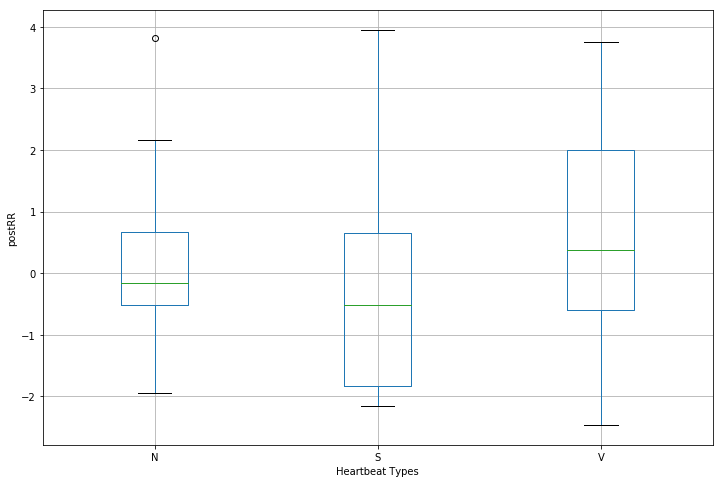

In [14]:
featureId = 0

N_Type = []
S_Type = []
V_Type = []


for idx, label in enumerate(lev2_tr_label):
    if label in N:
        N_Type.append(lev2_tr_scaledData[idx][featureId])
    elif label in SVEB:
        S_Type.append(lev2_tr_scaledData[idx][featureId])
    elif label in VEB:
        V_Type.append(lev2_tr_scaledData[idx][featureId])
    else:
        continue
        
Ploter = pd.DataFrame({
    'N': random.sample(N_Type, 200),
    'S': random.sample(S_Type, 200),
    'V': random.sample(V_Type, 200)
})

Ploter.boxplot(figsize=(12,8)) 
plt.ylabel("postRR")
plt.xlabel("Heartbeat Types")

print('N postRR mean: ', Ploter['N'].mean())
print('N postRR std: ', Ploter['N'].std())
print()
print('S postRR mean: ', Ploter['S'].mean())
print('S postRR std: ', Ploter['S'].std())
print()
print('V postRR mean: ', Ploter['V'].mean())
print('V postRR std: ', Ploter['V'].std())
print()

print('P-Values')
_, p = ttest_ind(Ploter['N'], Ploter['S'])
print('N-S', p)
_, p = ttest_ind(Ploter['N'], Ploter['V'])
print('N-V', p)
_, p = ttest_ind(Ploter['S'], Ploter['V'])
print('S-V', p)

#### preRR

N preRR mean:  0.12906988441501846
N preRR std:  0.9043531715122931

S preRR mean:  -1.3589426976369725
S preRR std:  0.6398990436034823

V preRR mean:  -1.0671338973735554
V preRR std:  0.7846564277450689

P-Values
N-S 9.811917117962828e-58
N-V 5.0590471414953305e-37
S-V 5.536773894271791e-05


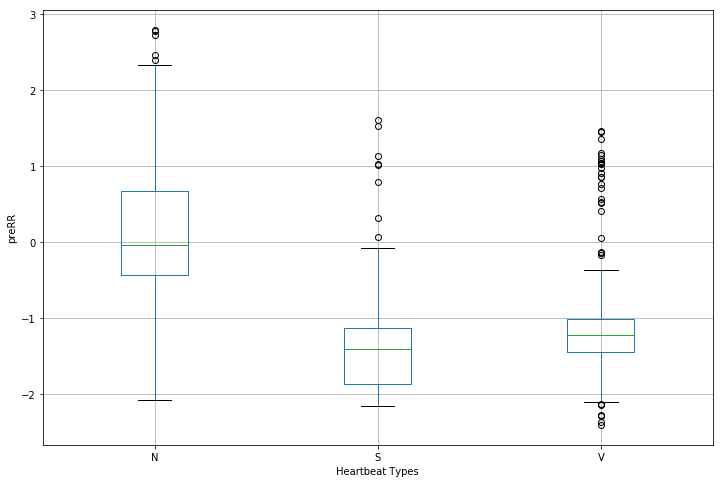

In [15]:
featureId = 1

N_Type = []
S_Type = []
V_Type = []


for idx, label in enumerate(lev2_tr_label):
    if label in N:
        N_Type.append(lev2_tr_scaledData[idx][featureId])
    elif label in SVEB:
        S_Type.append(lev2_tr_scaledData[idx][featureId])
    elif label in VEB:
        V_Type.append(lev2_tr_scaledData[idx][featureId])
    else:
        continue
        
Ploter = pd.DataFrame({
    'N': random.sample(N_Type, 200),
    'S': random.sample(S_Type, 200),
    'V': random.sample(V_Type, 200)
})

Ploter.boxplot(figsize=(12,8)) 
plt.ylabel("preRR")
plt.xlabel("Heartbeat Types")

print('N preRR mean: ', Ploter['N'].mean())
print('N preRR std: ', Ploter['N'].std())
print()
print('S preRR mean: ', Ploter['S'].mean())
print('S preRR std: ', Ploter['S'].std())
print()
print('V preRR mean: ', Ploter['V'].mean())
print('V preRR std: ', Ploter['V'].std())
print()

print('P-Values')
_, p = ttest_ind(Ploter['N'], Ploter['S'])
print('N-S', p)
_, p = ttest_ind(Ploter['N'], Ploter['V'])
print('N-V', p)
_, p = ttest_ind(Ploter['S'], Ploter['V'])
print('S-V', p)

#### skewness

N skewness mean:  0.09209681059090383
N skewness std:  0.9276606095650106

S skewness mean:  -0.40578156373139207
S skewness std:  1.003416531997434

V skewness mean:  -0.8560321676003179
V skewness std:  0.717505657675478

P-Values
N-S 4.0540643444100687e-07
N-V 2.2727312946832697e-26
S-V 3.8679569546887376e-07


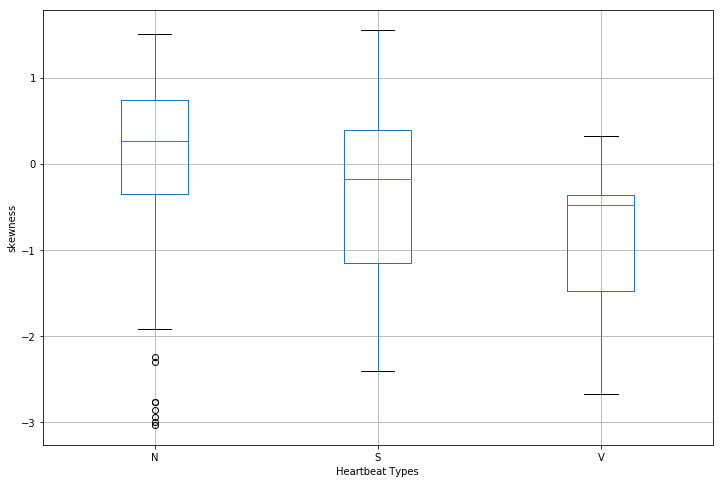

In [16]:
featureId = 2

N_Type = []
S_Type = []
V_Type = []


for idx, label in enumerate(lev2_tr_label):
    if label in N:
        N_Type.append(lev2_tr_scaledData[idx][featureId])
    elif label in SVEB:
        S_Type.append(lev2_tr_scaledData[idx][featureId])
    elif label in VEB:
        V_Type.append(lev2_tr_scaledData[idx][featureId])
    else:
        continue
        
Ploter = pd.DataFrame({
    'N': random.sample(N_Type, 200),
    'S': random.sample(S_Type, 200),
    'V': random.sample(V_Type, 200)
})

Ploter.boxplot(figsize=(12,8)) 
plt.ylabel("skewness")
plt.xlabel("Heartbeat Types")

print('N skewness mean: ', Ploter['N'].mean())
print('N skewness std: ', Ploter['N'].std())
print()
print('S skewness mean: ', Ploter['S'].mean())
print('S skewness std: ', Ploter['S'].std())
print()
print('V skewness mean: ', Ploter['V'].mean())
print('V skewness std: ', Ploter['V'].std())
print()

print('P-Values')
_, p = ttest_ind(Ploter['N'], Ploter['S'])
print('N-S', p)
_, p = ttest_ind(Ploter['N'], Ploter['V'])
print('N-V', p)
_, p = ttest_ind(Ploter['S'], Ploter['V'])
print('S-V', p)

#### kurtosis

N kurtosis mean:  0.10867194719797758
N kurtosis std:  0.9785114952876433

S kurtosis mean:  -0.4112829298385286
S kurtosis std:  0.8540102045816786

V kurtosis mean:  -1.3339816192873653
V kurtosis std:  0.3214264003768094

P-Values
N-S 2.8738603974005872e-08
N-V 2.8754234831588887e-61
S-V 9.99761727979165e-38


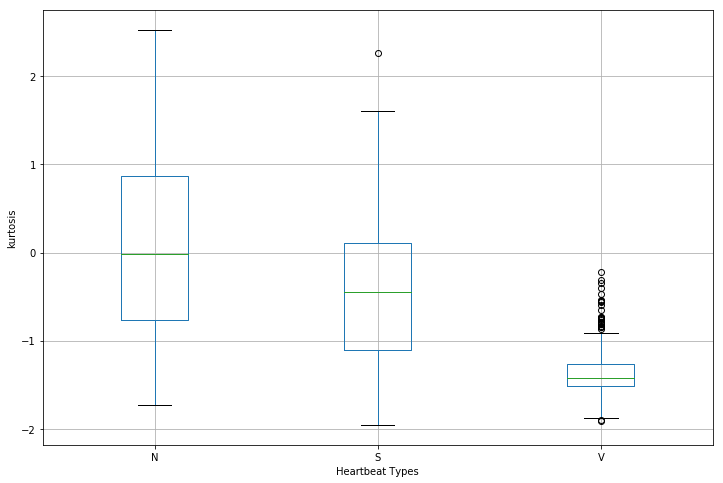

In [17]:
featureId = 3

N_Type = []
S_Type = []
V_Type = []


for idx, label in enumerate(lev2_tr_label):
    if label in N:
        N_Type.append(lev2_tr_scaledData[idx][featureId])
    elif label in SVEB:
        S_Type.append(lev2_tr_scaledData[idx][featureId])
    elif label in VEB:
        V_Type.append(lev2_tr_scaledData[idx][featureId])
    else:
        continue
        
Ploter = pd.DataFrame({
    'N': random.sample(N_Type, 200),
    'S': random.sample(S_Type, 200),
    'V': random.sample(V_Type, 200)
})

Ploter.boxplot(figsize=(12,8)) 
plt.ylabel("kurtosis")
plt.xlabel("Heartbeat Types")

print('N kurtosis mean: ', Ploter['N'].mean())
print('N kurtosis std: ', Ploter['N'].std())
print()
print('S kurtosis mean: ', Ploter['S'].mean())
print('S kurtosis std: ', Ploter['S'].std())
print()
print('V kurtosis mean: ', Ploter['V'].mean())
print('V kurtosis std: ', Ploter['V'].std())
print()

print('P-Values')
_, p = ttest_ind(Ploter['N'], Ploter['S'])
print('N-S', p)
_, p = ttest_ind(Ploter['N'], Ploter['V'])
print('N-V', p)
_, p = ttest_ind(Ploter['S'], Ploter['V'])
print('S-V', p)

#### Wavelet coefficients

cD7: 4-5
cD6: 6-9
cD5: 10-17
cD4: 18-32

cD7_0
N wf mean:  0.06755453011399093
N wf std:  0.7580911127355927

S wf mean:  0.6418569594717011
S wf std:  0.8353726271291003

V wf mean:  -0.37904917945312816
V wf std:  2.5025796569307714

P-Values
N-S 3.0324230305423026e-12
N-V 0.016168588260362812
S-V 7.872000287993623e-08


cD7_1
N wf mean:  0.11394507649012293
N wf std:  0.7887286473167613

S wf mean:  0.08625049458085854
S wf std:  0.9500128676173344

V wf mean:  -0.19028595898610967
V wf std:  2.2062137517761737

P-Values
N-S 0.7512602800496184
N-V 0.0670529838450435
S-V 0.10429336658976246




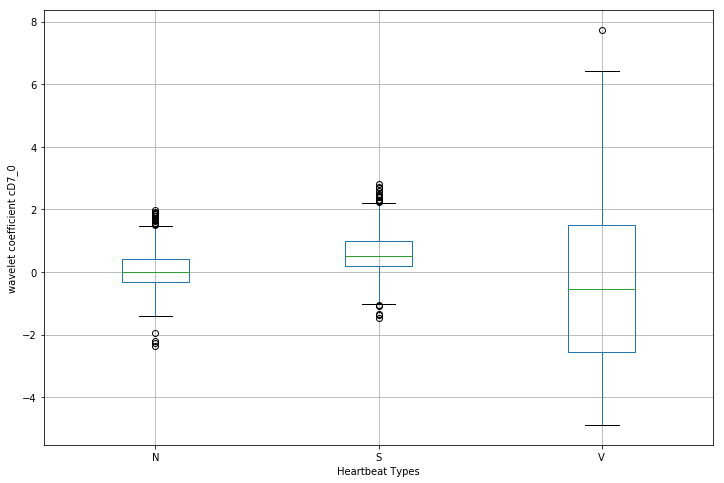

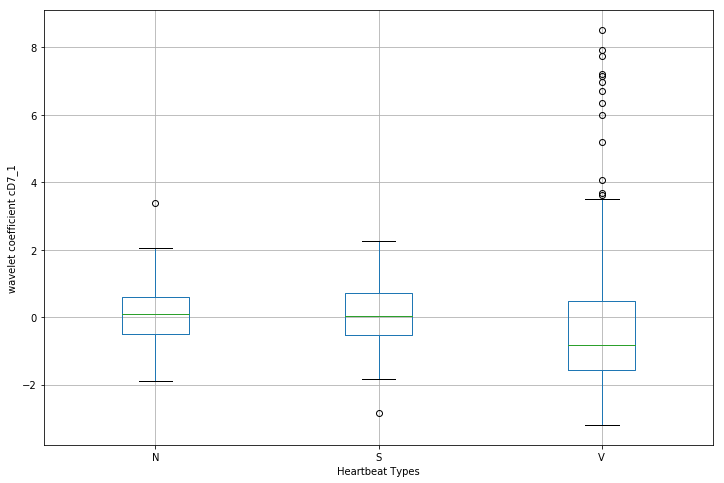

In [18]:
# change the two parameters below to indicate that which level's coefficients needs to be presented.
level = 'cD7'
locs = list(range(4,6))

for featureId in locs:
    N_Type = []
    S_Type = []
    V_Type = []

    for idx, label in enumerate(lev2_tr_label):
        if label in N:
            N_Type.append(lev2_tr_scaledData[idx][featureId])
        elif label in SVEB:
            S_Type.append(lev2_tr_scaledData[idx][featureId])
        elif label in VEB:
            V_Type.append(lev2_tr_scaledData[idx][featureId])
        else:
            continue

    Ploter = pd.DataFrame({
        'N': random.sample(N_Type, 200),
        'S': random.sample(S_Type, 200),
        'V': random.sample(V_Type, 200)
    })
    
    plt.figure(figsize=(12,8))

    Ploter.boxplot(figsize=(12,8)) 
    plt.ylabel("wavelet coefficient " + level + "_" + str(featureId-locs[0]))
    plt.xlabel("Heartbeat Types")

    print(level + '_' + str(featureId-locs[0]))

    print('N wf mean: ', Ploter['N'].mean())
    print('N wf std: ', Ploter['N'].std())
    print()
    print('S wf mean: ', Ploter['S'].mean())
    print('S wf std: ', Ploter['S'].std())
    print()
    print('V wf mean: ', Ploter['V'].mean())
    print('V wf std: ', Ploter['V'].std())
    
    print()
    print('P-Values')
    _, p1 = ttest_ind(Ploter['N'], Ploter['S'])
    print('N-S', p1)
    _, p2 = ttest_ind(Ploter['N'], Ploter['V'])
    print('N-V', p2)
    _, p3 = ttest_ind(Ploter['S'], Ploter['V'])
    print('S-V', p3)
    print()
    
    print('================================================================')
    print()

# Training --- DS1

### Treshold training

In [19]:
trsValues = {}
TR_postRR = {}
TR_preRR = {}
    
for ds in DS1:
    TR_postRR[ds] = []
    TR_preRR[ds] = []

    TR_min = min(np.min(lev1_tr_data[ds][:, 0]), np.min(lev1_tr_data[ds][:, 1]))
    TR_max = max(np.max(lev1_tr_data[ds][:, 0]), np.max(lev1_tr_data[ds][:, 1]))

    for beat in lev1_tr_data[ds]:
        TR_postRR[ds].append((beat[1]-TR_min)/(TR_max-TR_min))
        TR_preRR[ds].append((beat[0]-TR_min)/(TR_max-TR_min))

    TR_N = []
    TR_S = []
    TR_Real = []

    for idx, label in enumerate(lev1_tr_label[ds]):
        if label in N:
            TR_N.append([TR_preRR[ds][idx], TR_postRR[ds][idx]])
            TR_Real.append('N')
        if label in SVEB:
            TR_S.append([TR_preRR[ds][idx], TR_postRR[ds][idx]])
            TR_Real.append('S')

    TR_N = np.array(TR_N)
    TR_S = np.array(TR_S)


    TR_MEDIAN_PRERR = np.median(TR_N[:, 0])

    TR_T = 0
    TR_Step = 0.05
    TR_Best = 0
    TR_Best_T = 0

    while TR_T > -1:
        TR_Predict = []
        for idx, label in enumerate(lev1_tr_label[ds]):
            if label not in N and label not in SVEB:
                continue
            if (TR_preRR[ds][idx] - TR_postRR[ds][idx])/TR_MEDIAN_PRERR < TR_T:
                TR_Predict.append('S')
            elif (TR_preRR[ds][idx] - TR_MEDIAN_PRERR)/TR_MEDIAN_PRERR < TR_T:
                TR_Predict.append('S')
            else:
                TR_Predict.append('N')
        N_Result = list(confusion_matrix(TR_Real, TR_Predict, labels=['N', 'S'])[0])
        S_Result = list(confusion_matrix(TR_Real, TR_Predict, labels=['N', 'S'])[1])
        N_Sen = N_Result[0] / (N_Result[0] + N_Result[1])
        S_Sen = S_Result[1] / (S_Result[0] + S_Result[1])
        if N_Sen + S_Sen > TR_Best:
            TR_Best = N_Sen + S_Sen
            TR_Best_T = TR_T
        TR_T -= TR_Step
    trsValues[ds] = TR_Best_T

In [20]:
trsValues

{'101': -0.49999999999999994,
 '106': 0,
 '108': -0.8500000000000002,
 '109': 0,
 '112': -0.35,
 '114': -0.3,
 '115': 0,
 '116': -0.49999999999999994,
 '118': -0.44999999999999996,
 '119': 0,
 '122': 0,
 '124': -0.2,
 '201': -0.5499999999999999,
 '203': -0.5499999999999999,
 '205': -0.2,
 '207': -0.49999999999999994,
 '208': -0.15000000000000002,
 '209': -0.39999999999999997,
 '215': -0.44999999999999996,
 '220': -0.2,
 '223': -0.3,
 '230': 0}

### Classifier training

#### Classifier pool

In [21]:
model_perceptron = CalibratedClassifierCV(Perceptron(max_iter=100))
model_linear_svm = CalibratedClassifierCV(LinearSVC())
model_svc = SVC(probability=True)
model_bayes = GaussianNB()
model_tree = DecisionTreeClassifier()
model_knn = KNeighborsClassifier(n_neighbors=5)
model_lr = LogisticRegression(random_state=1)

#### NV data preparation

In [22]:
NV_tr_data = []
NV_tr_label = []


for idx, label in enumerate(lev2_tr_label):
    if label in SVEB:
        continue
    else:
        NV_tr_data.append(lev2_tr_scaledData[idx][:-2])
        NV_tr_label.append(label)

#### NVDispatcher

In [23]:
NVDispatcher = VotingClassifier(estimators=[
    ('ls', model_linear_svm), ('svc', model_svc), 
    ('tree', model_tree), ('knn', model_knn), ('lr', model_lr),('pt', model_perceptron), ('ba', model_bayes)
], voting='hard')   


NVDispatcher.fit(NV_tr_data, NV_tr_label)

VotingClassifier(estimators=[('ls', CalibratedClassifierCV(base_estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
            cv=3, method='s...verbose=0, warm_start=False),
            cv=3, method='sigmoid')), ('ba', GaussianNB(priors=None))],
         flatten_transform=None, n_jobs=1, voting='hard', weights=None)

#### SV data preparation

In [24]:
SV_data = []
SV_label = []
FQ_data = []
FQ_label = []

for idx, label in enumerate(lev2_tr_label):
    if label in N:
        continue
    if label in F or label in Q:
        FQ_data.append(lev2_tr_scaledData[idx][2:-2])   # the RR-intervals are not used as features
        FQ_label.append(label)
        continue
    
    SV_data.append(lev2_tr_scaledData[idx][2:-2])  # the RR-intervals are not used as features
    SV_label.append(label)

smote_enn = SMOTEENN(random_state=0)
data_resampled, label_resampled = smote_enn.fit_sample(np.array(SV_data), np.array(SV_label))

SV_tr_data = np.append(data_resampled, np.array(FQ_data), axis=0)
SV_tr_label = np.append(label_resampled, np.array(FQ_label), axis=0)

#### SVDispatcher

In [25]:
SVDispatcher = SVC(probability=True)
SVDispatcher.fit(SV_tr_data, SV_tr_label)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

# Testing --- DS2

#### DS2Neighbors

In [26]:
DS2Neighbors = {}
TE_postRR = {}
TE_preRR = {}

for ds2 in DS2:
    DS2Neighbors[ds2] = ['-1', 100, 0]
    TE_postRR[ds2] = []
    TE_preRR[ds2] = []

    TE_min = min(np.min(lev1_ev_data[ds2][:, 0]), np.min(lev1_ev_data[ds2][:, 1]))
    TE_max = max(np.max(lev1_ev_data[ds2][:, 0]), np.max(lev1_ev_data[ds2][:, 1]))

    for beat in lev1_ev_data[ds2]:
        TE_postRR[ds2].append((beat[1]-TE_min)/(TE_max-TE_min))
        TE_preRR[ds2].append((beat[0]-TE_min)/(TE_max-TE_min))


    for ds1 in DS1:
        if emd_samples(TR_preRR[ds1], TE_preRR[ds2]) < DS2Neighbors[ds2][1]:
            DS2Neighbors[ds2][0] = ds1
            DS2Neighbors[ds2][1] = emd_samples(TR_preRR[ds1], TE_preRR[ds2])
            if trsValues[ds1] == 0:
                DS2Neighbors[ds2][2] = min(trsValues.values())
            else:
                DS2Neighbors[ds2][2] = trsValues[ds1]

#### Lev1 classification

In [27]:
TE_MEDIAN_PRERR = {}
TE_Predict = []

for ds in DS2:
    df = pd.DataFrame({
        'preRR': TE_preRR[ds],
    })
    
    fig, stats = df.boxplot(return_type='both')
    temp = fig.remove()  # remove the boxplot in the output
    outliers = [flier.get_ydata() for flier in stats["fliers"]]   # get outliers from the boxplot statistics
    
    if len(outliers[0]) / len(TE_preRR[ds]) > 0.1:
        TE_MEDIAN_PRERR[ds] = np.mean([np.mean(outliers[0]), np.median(TE_preRR[ds])])
    else:
        TE_MEDIAN_PRERR[ds] = np.median(TE_preRR[ds])

for idx, label in enumerate(lev2_ev_label):
    ds = lev2_ev_dsIndicatior[idx][0]
    ds_idx = lev2_ev_dsIndicatior[idx][1]
         
    if (TE_preRR[ds][ds_idx] - TE_postRR[ds][ds_idx]) / TE_MEDIAN_PRERR[ds] < DS2Neighbors[ds][2]:
        TE_Predict.append('S')
    elif (TE_preRR[ds][ds_idx] - TE_MEDIAN_PRERR[ds]) / TE_MEDIAN_PRERR[ds] < DS2Neighbors[ds][2]:
        TE_Predict.append('S')
    else:
        TE_Predict.append('N')
            
cm = confusion_matrix(lev2_ev_label, TE_Predict, labels=['N', 'S'])

print(cm)

[[40918  3151]
 [   74  1680]]


<Figure size 432x288 with 0 Axes>

In [28]:
cm = confusion_matrix(lev2_ev_label, TE_Predict, labels=['N', 'S', 'V', 'F', 'Q'])

print(cm)

[[40918  3151     0     0     0]
 [   74  1680     0     0     0]
 [  872  2347     0     0     0]
 [  383     5     0     0     0]
 [    5     2     0     0     0]]


#### Lev2 classification

In [29]:
for idx, label in enumerate(TE_Predict):
    if label in N:
        TE_Predict[idx] = list(NVDispatcher.predict([lev2_ev_scaledData[idx][:-2]]))[0]
                                                        
    elif label in SVEB:
        TE_Predict[idx] = list(SVDispatcher.predict([lev2_ev_scaledData[idx][2:-2]]))[0]
    else:
        continue
        
cm = confusion_matrix(lev2_ev_label, TE_Predict, labels=['N', 'S', 'V', 'F', 'Q'])
print(cm)

[[40735  2762   523    49     0]
 [   71  1593    87     3     0]
 [  124   151  2833   111     0]
 [  303     1    60    24     0]
 [    2     0     4     1     0]]


#### Result summary

In [30]:
cm = confusion_matrix(lev2_ev_label, TE_Predict, labels=['N', 'S', 'V','F','Q'])

    
print('DS2' + ' & ' 
      + str(sum(cm[0])) + ' & ' 
      + str(sum(cm[1])) + ' & ' 
      + str(sum(cm[2])) + ' && ' 
      + str(round(accuracy_score(lev2_ev_label, TE_Predict) * 100, 2)) + ' & ' 
      + str(round(cm[0][0]/sum(cm[0]) * 100, 2)) + ' & ' 
      + str(round(cm[0][0]/sum(cm[:, 0]) * 100, 2)) + ' && ' 
      + str(round(cm[1][1]/sum(cm[1]) * 100, 2) ) + ' & '
      + str(round(cm[1][1]/sum(cm[:, 1]) * 100, 2)) + ' && '
      + str(round(cm[2][2]/sum(cm[2]) * 100, 2)) + ' & '
      + str(round(cm[2][2]/sum(cm[:, 2]) * 100, 2)) + ' & \\\\'
     )

print()

print('ACC: ' + str(accuracy_score(lev2_ev_label, TE_Predict)))
print()
print('N Total: ' + str(sum(cm[0])))
print('S Total: ' + str(sum(cm[1])))
print('V Total: ' + str(sum(cm[2])))
print()
print('N Sen: ' + str(round(cm[0][0]/sum(cm[0]), 3)))
print('N +P: ' + str(round(cm[0][0]/sum(cm[:, 0]), 3)))
print()
print('S Sen: ' + str(round(cm[1][1]/sum(cm[1]), 3)))
print('S +P: ' + str(round(cm[1][1]/sum(cm[:, 1]), 3)))
print()
print('V Sen: ' + str(round(cm[2][2]/sum(cm[2]), 3)))
print('V +P: ' + str(round(cm[2][2]/sum(cm[:, 2]), 3)))

DS2 & 44069 & 1754 & 3219 && 91.4 & 92.43 & 98.79 && 90.82 & 35.35 && 88.01 & 80.78 & \\

ACC: 0.9139915447943848

N Total: 44069
S Total: 1754
V Total: 3219

N Sen: 0.924
N +P: 0.988

S Sen: 0.908
S +P: 0.353

V Sen: 0.88
V +P: 0.808


# Generalizing --- INCART

#### INCARTNeighbors

In [31]:
INCARTNeighbors = {}
GE_postRR = {}
GE_preRR = {}

for incart in INCART:
    INCARTNeighbors[incart] = ['-1', 100, 0]
    GE_postRR[incart] = []
    GE_preRR[incart] = []

    GE_min = min(np.min(lev1_ge_data[incart][:, 0]), np.min(lev1_ge_data[incart][:, 1]))
    GE_max = max(np.max(lev1_ge_data[incart][:, 0]), np.max(lev1_ge_data[incart][:, 1]))

    for beat in lev1_ge_data[incart]:
        GE_postRR[incart].append((beat[1]-GE_min)/(GE_max-GE_min))
        GE_preRR[incart].append((beat[0]-GE_min)/(GE_max-GE_min))


    for ds1 in DS1:
        if emd_samples(TR_preRR[ds1], GE_preRR[incart]) < INCARTNeighbors[incart][1]:
            INCARTNeighbors[incart][0] = ds1
            INCARTNeighbors[incart][1] = emd_samples(TR_preRR[ds1], GE_preRR[incart])
            if trsValues[ds1] == 0:
                INCARTNeighbors[incart][2] = min(trsValues.values())
            else:
                INCARTNeighbors[incart][2] = trsValues[ds1]

#### Lev1 classification

In [32]:
GE_MEDIAN_PRERR = {}
GE_Predict = []

for ds in INCART:
    df = pd.DataFrame({
        'preRR': GE_preRR[ds],
    })
    
    fig, stats = df.boxplot(return_type='both')
    temp = fig.remove()  # remove the boxplot in the output
    outliers = [flier.get_ydata() for flier in stats["fliers"]]   # get outliers from the boxplot statistics
    
    if len(outliers[0]) / len(GE_preRR[ds]) > 0.1:
        GE_MEDIAN_PRERR[ds] = np.mean([np.mean(outliers[0]), np.median(GE_preRR[ds])])
    else:
        GE_MEDIAN_PRERR[ds] = np.median(GE_preRR[ds])
        
for idx, label in enumerate(lev2_ge_label):
    ds = lev2_ge_dsIndicatior[idx][0]
    ds_idx = lev2_ge_dsIndicatior[idx][1]
        
    if (GE_preRR[ds][ds_idx] - GE_postRR[ds][ds_idx]) / GE_MEDIAN_PRERR[ds] < INCARTNeighbors[ds][2]:
        GE_Predict.append('S')
    elif (GE_preRR[ds][ds_idx] - GE_MEDIAN_PRERR[ds]) / GE_MEDIAN_PRERR[ds] < INCARTNeighbors[ds][2]:
        GE_Predict.append('S')
    else:
        GE_Predict.append('N')
            
cm = confusion_matrix(lev2_ge_label, GE_Predict, labels=['N', 'S'])

print(cm)

[[141861  11630]
 [   110   1848]]


<Figure size 432x288 with 0 Axes>

#### Lev2 classification

In [33]:
for idx, label in enumerate(GE_Predict):
    if label in N:
        GE_Predict[idx] = list(NVDispatcher.predict([lev2_ge_scaledData[idx][:-2]]))[0]
                                                        
    elif label in SVEB:
        GE_Predict[idx] = list(SVDispatcher.predict([lev2_ge_scaledData[idx][2:-2]]))[0]
    else:
        continue
        
cm = confusion_matrix(lev2_ge_label, GE_Predict, labels=['N', 'S', 'V', 'F', 'Q'])
print(cm)

[[138620   6871   6284   1716      0]
 [   106   1554    204     94      0]
 [   695   1639  17383    276      0]
 [   108      4     53     54      0]
 [     3      0      3      0      0]]


#### Result summary

In [34]:
cm = confusion_matrix(lev2_ge_label, GE_Predict, labels=['N', 'S', 'V','F','Q'])

    
print('INCART' + ' & ' 
      + str(sum(cm[0])) + ' & ' 
      + str(sum(cm[1])) + ' & ' 
      + str(sum(cm[2])) + ' && ' 
      + str(round(accuracy_score(lev2_ge_label, GE_Predict) * 100, 2)) + ' & ' 
      + str(round(cm[0][0]/sum(cm[0]) * 100, 2)) + ' & ' 
      + str(round(cm[0][0]/sum(cm[:, 0]) * 100, 2)) + ' && ' 
      + str(round(cm[1][1]/sum(cm[1]) * 100, 2) ) + ' & '
      + str(round(cm[1][1]/sum(cm[:, 1]) * 100, 2)) + ' && '
      + str(round(cm[2][2]/sum(cm[2]) * 100, 2)) + ' & '
      + str(round(cm[2][2]/sum(cm[:, 2]) * 100, 2)) + ' & \\\\'
     )

print()

print('ACC: ' + str(accuracy_score(lev2_ge_label, GE_Predict)))
print()
print('N Total: ' + str(sum(cm[0])))
print('S Total: ' + str(sum(cm[1])))
print('V Total: ' + str(sum(cm[2])))
print()
print('N Sen: ' + str(round(cm[0][0]/sum(cm[0]), 3)))
print('N +P: ' + str(round(cm[0][0]/sum(cm[:, 0]), 3)))
print()
print('S Sen: ' + str(round(cm[1][1]/sum(cm[1]), 3)))
print('S +P: ' + str(round(cm[1][1]/sum(cm[:, 1]), 3)))
print()
print('V Sen: ' + str(round(cm[2][2]/sum(cm[2]), 3)))
print('V +P: ' + str(round(cm[2][2]/sum(cm[:, 2]), 3)))

INCART & 153491 & 1958 & 19993 && 89.72 & 90.31 & 99.35 && 79.37 & 15.44 && 86.95 & 72.65 & \\

ACC: 0.8972146162910507

N Total: 153491
S Total: 1958
V Total: 19993

N Sen: 0.903
N +P: 0.993

S Sen: 0.794
S +P: 0.154

V Sen: 0.869
V +P: 0.727
